# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split as tts

# Data Exploring

In [19]:
ds = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',names=['id','entity','sentiment','content'])
# ds = ds.drop(columns=['index','word'])
ds.head()

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [20]:
ds.entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [21]:
ds.shape

(74682, 4)

([<matplotlib.patches.Wedge at 0x1f9cf36a9b0>,
 [Text(-0.8936408809046303, 0.6414093669225578, 'neg'),
  Text(-0.39649770564254117, -1.0260553442286633, 'pos'),
  Text(1.0532293937999033, -0.3173449921392938, 'neu'),
  Text(0.5716146417662045, 0.9398173765782871, 'irr')],
 [Text(-0.4874404804934347, 0.3498596546850315, '30.18%'),
  Text(-0.21627147580502246, -0.5596665513974527, '27.89%'),
  Text(0.5744887602544927, -0.17309726843961476, '24.53%'),
  Text(0.31178980459974787, 0.5126276599517929, '17.39%')])

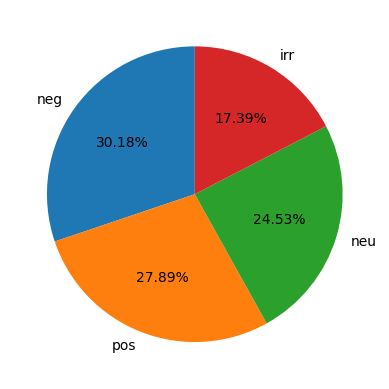

In [22]:
plt.pie(ds.sentiment.value_counts(),labels=['neg','pos','neu','irr'],autopct='%1.2f%%',startangle=90)

In [23]:
ds.sentiment.value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

# Data Cleaning

In [24]:
ds.duplicated().sum()

2700

In [25]:
ds.drop_duplicates(inplace=True)

In [26]:
ds.duplicated().sum()

0

In [27]:
ds.isnull().sum()

id             0
entity         0
sentiment      0
content      326
dtype: int64

In [28]:
ds.dropna(axis=0,inplace=True)
ds.reset_index(inplace=True)

In [29]:
ds.isnull().sum()

index        0
id           0
entity       0
sentiment    0
content      0
dtype: int64

In [30]:
ds.shape

(71656, 5)

# Text Preprocessing

In [31]:
ds.head()

,index,id,entity,sentiment,content
0,0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [43]:
replace_list = {r"im": 'i am',
                r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

In [44]:
x = ds['content']
x = x[:10000]
x.head()

0    im getting on borderlands and i will murder yo...
1    I am coming to the borders and I will kill you...
2    im getting on borderlands and i will kill you ...
3    im coming on borderlands and i will murder you...
4    im getting on borderlands 2 and i will murder ...
Name: content, dtype: object

In [34]:
ps = PorterStemmer()
lem = WordNetLemmatizer()

In [35]:
corpus = []
for i in range(len(x)):
    r = x[i]
    r = r.lower()
    for j in replace_list: r = r.replace(j,replace_list[j])
    r = r.split()
    r = [ps.stem(w) for w in r if not w in stopwords.words('english')]
    # r = [lem.lemmatize(w) for w in r if w not in set(stopwords.words('english'))]
    r = ' '.join(r)
    corpus.append(r)
print(corpus[:5])

['get borderland murder ,', 'come border kill ,', 'get borderland kill ,', 'come borderland murder ,', 'get borderland 2 murder ,']


max tweet length : 213


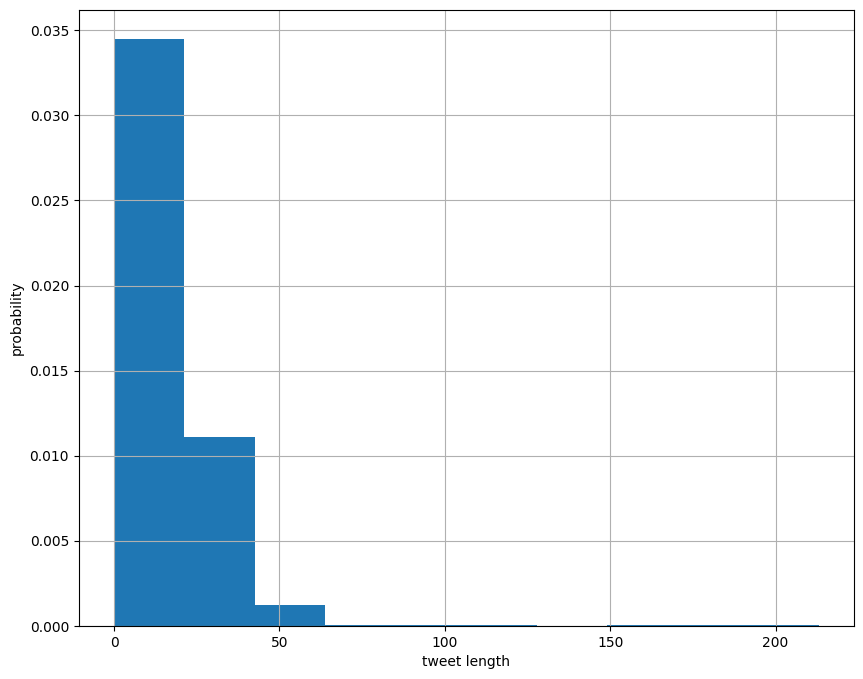

In [36]:
df = pd.Series(v for v in corpus)
length_of_tweets = df.apply(lambda p : len(p.split()))
max_length = length_of_tweets.max()
print('max tweet length :', max_length)
plt.figure(figsize=(10,8))
plt.xlabel('tweet length')
plt.ylabel('probability')
plt.hist(length_of_tweets, density=True)
plt.grid()

In [37]:
y = ds['sentiment']
y = y[:10000]
y.head()

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: sentiment, dtype: object

In [38]:
x = corpus
max_words = 8000
token = Tokenizer(num_words=max_words, filters='"#$%&()*+-/:;<=>@[\]^_`{|}~')
token.fit_on_texts(x)
x = token.texts_to_sequences(x)
x = pad_sequences(x,maxlen=300)

In [39]:
lt = Tokenizer()
lt.fit_on_texts(y)
y = np.array(lt.texts_to_sequences(y))
y[:5]#pos=3, neutral=2, neg=1

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [40]:
x.shape, y.shape

((10000, 300), (10000, 1))

# Model

In [41]:
xtr, xte, ytr, yte = tts(x, y, test_size=.2, random_state=0)

In [42]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=300))
model.add(SpatialDropout1D(.3))
model.add(LSTM(128, dropout=.3, recurrent_dropout=.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.3))
model.add(Dense(5,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 300, 128)          1024000   

                                                                 

 spatial_dropout1d (SpatialD  (None, 300, 128)         0         

 ropout1D)                                                       

                                                                 

 lstm (LSTM)                 (None, 128)               131584    

                                                                 

 dense (Dense)               (None, 128)               16512     

                                                                 

 dropout (Dropout)           (None, 128)               0         

                                                                 

 dense_1 (Dense)             (None, 5)                 645       

                                        

In [72]:
history = model.fit(xtr, ytr, validation_data=(xte, yte), epochs=10, batch_size=100)

Epoch 1/10

250/250 [==============================] - 397s 2s/step - loss: 1.2397 - accuracy: 0.4311 - val_loss: 0.8728 - val_accuracy: 0.6645

Epoch 2/10

250/250 [==============================] - 392s 2s/step - loss: 0.5935 - accuracy: 0.7775 - val_loss: 0.4224 - val_accuracy: 0.8470

Epoch 3/10

250/250 [==============================] - 350s 1s/step - loss: 0.2900 - accuracy: 0.9006 - val_loss: 0.3624 - val_accuracy: 0.8700

Epoch 4/10

250/250 [==============================] - 374s 1s/step - loss: 0.1918 - accuracy: 0.9301 - val_loss: 0.3146 - val_accuracy: 0.8905

Epoch 5/10

250/250 [==============================] - 388s 2s/step - loss: 0.1465 - accuracy: 0.9461 - val_loss: 0.3154 - val_accuracy: 0.9000

Epoch 6/10

250/250 [==============================] - 370s 1s/step - loss: 0.1293 - accuracy: 0.9495 - val_loss: 0.3539 - val_accuracy: 0.8900

Epoch 7/10

250/250 [==============================] - 346s 1s/step - loss: 0.1134 - accuracy: 0.9556 - val_loss: 0.3432 - val_acc

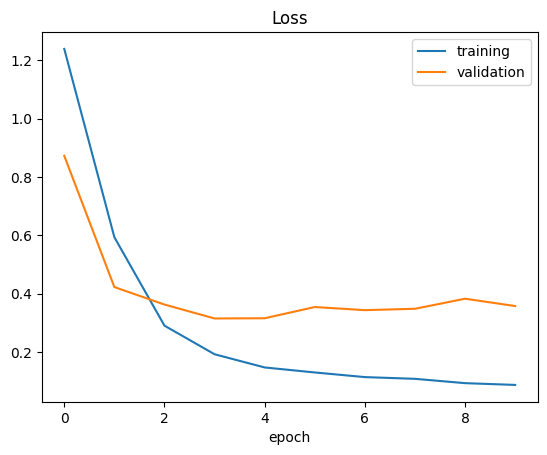

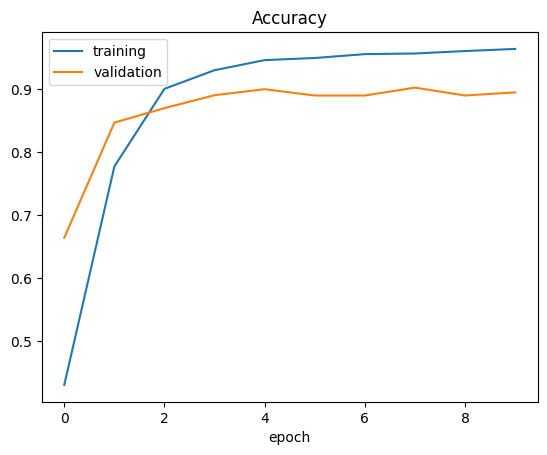

In [78]:
plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
yp = model.predict(xte)
yp = np.where(yp > 0.6, 1,0)

In [85]:
model.save('Twitter')

INFO:tensorflow:Assets written to: Twitter\assets


INFO:tensorflow:Assets written to: Twitter\assets
